## Data cleaning protocol

The dataset is plenty of extreme (very low or very high) values of trip distances, durations, speeds. Here, we try to determine good cut points for filtering the "true trips" with a reasonable degree of precision.

Extreme values can be due to:
* test data
* errors in capture or dataset generation
* trip abandonment at the start
* people who keep a bike at home for long time
* bike transportation inside motor vehicles
* ... ?

### Libraries and setup

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from yellow import trips as yt
from yellow import plots
from yellow import trajectories as traj

distance_filters = ['up to 50m', 'between 50m and 20km', 'above 20km']
duration_filters = ['up to 1 minute', 'between 1min and 2h', 'above 2h']

SMALL = 0
NORMAL = 1
BIG = 2

### Input data
Filter São Paulo trips and load precalculated metrics. These come from notebooks:
* [1-Separating-Cities.ipynb](1-Separating-Cities.ipynb)
* [3-Trajectory-Statistics.ipynb](3-Trajectory-Statistics.ipynb)

In [2]:
trips = pd.read_csv('~/saida.csv')
cities = pd.read_csv('~/cities.csv')
stats = pd.read_csv('~/traj-stats.csv')
trips = trips.merge(cities[cities.city == 'São Paulo'], on='tripid') \
             .merge(stats[(stats.num_takes > 1) &
                          (stats.total_duration > 0) &
                          (stats.total_distance > 0)], on='tripid')
trips['start_time'] = yt.extract_start_times(trips)

### Trips classification
* **Distance**
  * < 50m
  * [50m, 20km]
  * $>$ 20km
* **Duration**
  * < 1 min
  * [1 min, 2 hours]
  * $>$ 2 hours

In [3]:
def classification(row):
    if row.total_distance < 50:
        distance_class = distance_filters[SMALL]
    elif row.total_distance > 20*1000:
        distance_class = distance_filters[BIG]
    else:
        distance_class = distance_filters[NORMAL]
    
    if row.total_duration < 60:
        duration_class = duration_filters[SMALL]
    elif row.total_distance > 2*60*60:
        duration_class = duration_filters[BIG]
    else:
        duration_class = duration_filters[NORMAL]

    return distance_class, duration_class
    
trips[['distance_class', 'duration_class']] = trips.apply(classification, axis=1, result_type='expand')

### Two key periods
* Up to Oct 25, 2018
* From Oct 25, 2018

In [4]:
period1 = trips[trips.start_time < pd.Timestamp('2018-10-25 00:00:00')]
period2 = trips[trips.start_time >= pd.Timestamp('2018-10-25 00:00:00')]
len(period1), len(period2)

(19935, 276119)

### Classification matrixes

* First period

In [5]:
p1class = period1.groupby(['distance_class', 'duration_class']).agg({'tripid': 'count'})
p1class.rename(columns={'tripid': 'countings'}, inplace=True)
p1class = p1class.unstack().fillna(0)
p1class

countings                                   
duration_class        above 2h between 1min and 2h up to 1 minute
distance_class                                                   
above 20km                 1.0                 0.0            0.0
between 50m and 20km      16.0                83.0           97.0
up to 50m                  0.0              1790.0        17948.0

In [6]:
p1class / len(period1)

countings                                   
duration_class        above 2h between 1min and 2h up to 1 minute
distance_class                                                   
above 20km            0.000050            0.000000       0.000000
between 50m and 20km  0.000803            0.004164       0.004866
up to 50m             0.000000            0.089792       0.900326

**First group is mostly made of very short trips, in durantion and in distance.**

* Second period

In [7]:
p2class = period2.groupby(['distance_class', 'duration_class']).agg({'tripid': 'count'})
p2class.rename(columns={'tripid': 'countings'}, inplace=True)
p2class = p2class.unstack().fillna(0)
p2class

countings                                   
duration_class        above 2h between 1min and 2h up to 1 minute
distance_class                                                   
above 20km              2884.0                 0.0            4.0
between 50m and 20km    9570.0            222170.0         4850.0
up to 50m                  0.0              9815.0        26826.0

In [8]:
p2class / len(period2)

countings                                   
duration_class        above 2h between 1min and 2h up to 1 minute
distance_class                                                   
above 20km            0.010445            0.000000       0.000014
between 50m and 20km  0.034659            0.804617       0.017565
up to 50m             0.000000            0.035546       0.097154

### Relevant trips for deeper analysis
* From Oct 25, 2018
* Duration from 1 minute
* Distance from 50m

In [9]:
relevant = period2[(period2.total_distance >= 50) & (period2.total_duration >= 60)]
print(len(relevant), 'relevant trips')

234624 relevant trips


### Segment average speeds
Taken as a measure of reasonability inside group. From notebook [3.f-Instant-Speeds.ipynb](3.f-Instant-Speeds.ipynb)

In [10]:
speed_stats = pd.read_csv('~/traj-speed-stats.csv')
relevant = relevant.merge(speed_stats, on='tripid')
print(len(relevant), 'relevant trips')

234624 relevant trips


* Minimum segment speeds

In [11]:
relevant['min_speed'].describe()

count    234624.000000
mean          0.154413
std           0.626244
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          32.664483
Name: min_speed, dtype: float64

* Maximum segment speeds

In [12]:
relevant['max_speed'].describe()

count    2.346240e+05
mean     7.054693e+03
std      3.243297e+05
min      1.752869e-03
25%      2.184940e+01
50%      3.806043e+01
75%      1.280265e+02
max      9.137359e+07
Name: max_speed, dtype: float64

**There is a signifficant amount of high speed trips!**

In [13]:
selected = relevant[relevant.max_speed >= 60]
print(len(selected), 'trips with max segment speed of 60+ km/h')
(selected.max_speed//10*10).value_counts()

86047 trips with max segment speed of 60+ km/h


60.0          7336
70.0          5433
80.0          4285
90.0          3404
100.0         2892
110.0         2405
120.0         2037
130.0         1858
140.0         1673
150.0         1500
160.0         1282
170.0         1255
180.0         1126
190.0         1065
200.0         1000
210.0          892
230.0          805
220.0          796
250.0          762
240.0          702
290.0          658
270.0          626
260.0          623
280.0          589
300.0          577
310.0          570
320.0          539
330.0          514
340.0          487
350.0          469
              ... 
54740.0          1
90840.0          1
44880.0          1
73080.0          1
12270.0          1
291200.0         1
292330.0         1
55790.0          1
95460.0          1
380780.0         1
13600.0          1
122210.0         1
14640.0          1
148800.0         1
58540.0          1
21360.0          1
18690190.0       1
52890.0          1
211570.0         1
36510.0          1
78720.0          1
105800.0    

In [14]:
selected = relevant[(relevant.max_speed >= 60) & (relevant.max_speed <= 5000)]
plt.figure(figsize=(10, 10))
plots.dist_chart(selected.max_speed, 'high speed trips', 'max segment speed (km/h)')
plt.show()

### Relation between max segment speed and other variables
Here things get strange.
* Too many extreme values
* 'L' pattern (zoomed)
* Extreme durations with low distances/speeds are reasonable
  * People who keep a bike inside their homes

Trip duration

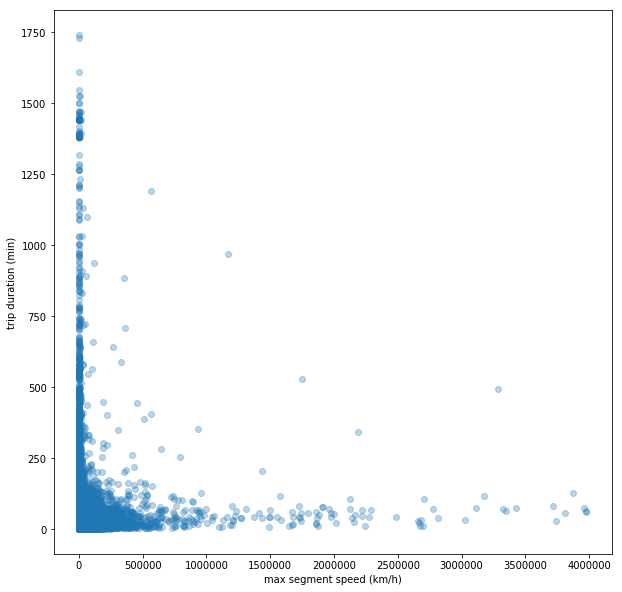

In [15]:
selected = relevant[(relevant.max_speed < 4e6) & (relevant.total_duration < 60*2000)]
plt.figure(figsize=(10, 10))
plt.xlabel('max segment speed (km/h)')
plt.ylabel('trip duration (min)')
plt.scatter(selected.max_speed, selected.total_duration/60, alpha=0.3)
plt.show()

Travelled distance

In [16]:
selected = relevant[(relevant.max_speed < 4e6) & (relevant.total_distance < 800*1000)]
plt.figure(figsize=(10, 10))
plt.xlabel('max segment speed (km/h)')
plt.ylabel('travelled distance (km)')
plt.scatter(selected.max_speed, selected.total_distance/1000, alpha=0.3)
plt.show()

Distance at the max speed segment

In [17]:
selected = relevant[(relevant.max_speed < 4e7)]
plt.figure(figsize=(10, 10))
plt.xlabel('max segment speed (km/h)')
plt.ylabel('distance at segment (km)')
plt.scatter(selected.max_speed, selected.dist_at_max/1000, alpha=0.3)
plt.show()

Duration at max speed segment

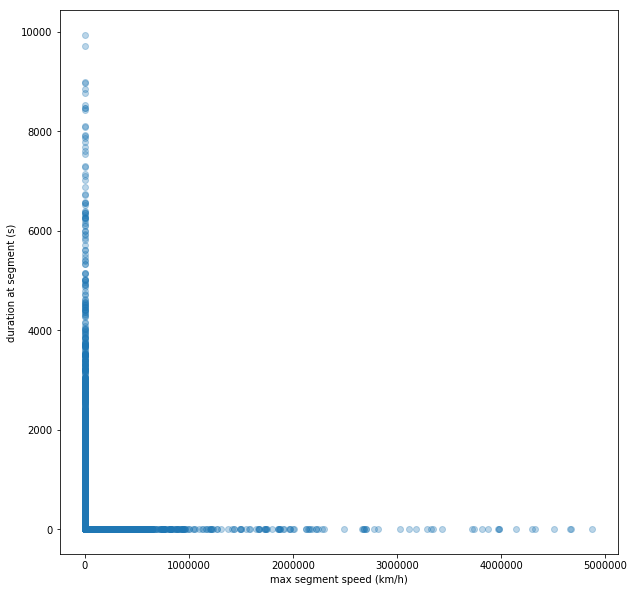

In [18]:
selected = relevant[(relevant.max_speed < 5e6) & (relevant.dur_at_max < 10000)]
plt.figure(figsize=(10, 10))
plt.xlabel('max segment speed (km/h)')
plt.ylabel('duration at segment (s)')
plt.scatter(selected.max_speed, selected.dur_at_max, alpha=0.3)
plt.show()

Street coverage

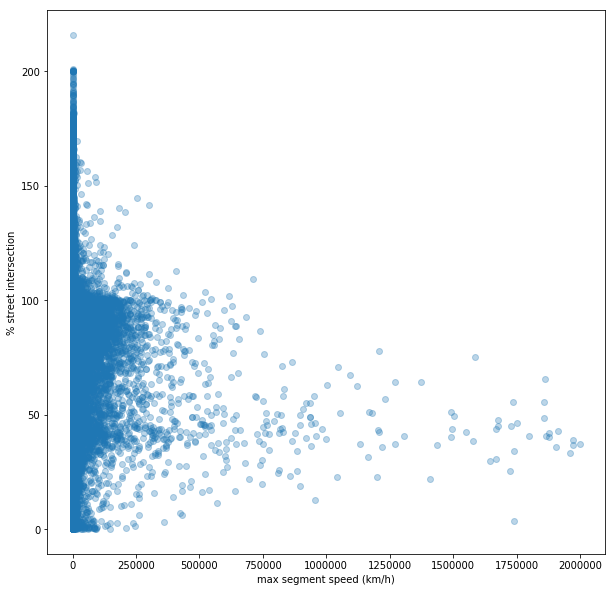

In [19]:
coverage = pd.read_csv('~/streets-coverage.csv')
merge = relevant.merge(coverage, on='tripid')
selected = merge[merge.max_speed < 2e6]
plt.figure(figsize=(10, 10))
plt.xlabel('max segment speed (km/h)')
plt.ylabel('% street intersection')
plt.scatter(selected.max_speed, selected.intersect_perc*100, alpha=0.3)
plt.show()

Street intersection count

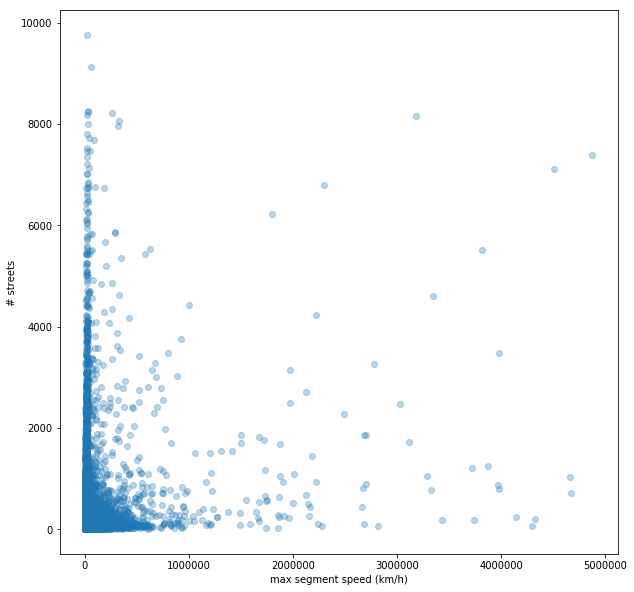

In [20]:
intersections = pd.read_csv('~/street-intersections.csv')
countings = intersections.groupby('tripid', as_index=False).agg({'ID': 'count'})
countings.columns = ['tripid', 'street_count']
merge = relevant.merge(countings, on='tripid')

selected = merge[(merge.max_speed < 5e6) & (merge.street_count < 10000)]
plt.figure(figsize=(10, 10))
plt.xlabel('max segment speed (km/h)')
plt.ylabel('# streets')
plt.scatter(selected.max_speed, selected.street_count, alpha=0.3)
plt.show()

### What more can we do?